# Evolución del lenguaje 3: Ver cómo ha variado el lenguaje mediante calculando vectores y comprobando qué episodios se parecen más entre sí usando word embedding

## Librerías

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fasttext
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Datos

In [3]:
df_episode = pd.read_csv('The Saimpsons Archive/in_use/simpsons_episodes.csv')

In [4]:
season_group_1 = range(1,11)
season_group_2 = range(11, 20)
season_group_3 = range(20, 29)

df_episode.loc[df_episode['season'].isin(season_group_1), 'season_group'] = 1
df_episode.loc[df_episode['season'].isin(season_group_2), 'season_group'] = 2
df_episode.loc[df_episode['season'].isin(season_group_3), 'season_group'] = 3
df_episode.sample(5)

# df_episode.to_csv('The Saimpsons Archive/in_use/simpsons_episodes_season_groups.csv')

,id,imdb_rating,imdb_votes,number_in_season,number_in_series,original_air_date,original_air_year,production_code,season,title,us_viewers_in_millions,views,season_group
437,427,7.1,728.0,7,427,2008-11-30,2008,KABF20,20,MyPods and Boomsticks,7.80,40353.0,3.0
63,168,8.9,1666.0,15,168,1997-02-16,1997,4F11,8,Homer's Phobia,15.30,63355.0,1.0
557,348,7.0,530.0,13,348,2005-03-20,2005,GABF07,16,Mobile Homer,8.49,45489.0,2.0
93,249,7.6,829.0,1,249,2000-11-01,2000,BABF21,12,Treehouse of Horror XI,13.20,77719.0,2.0
325,201,8.3,962.0,23,201,1998-05-03,1998,5F16,9,King of the Hill,9.20,60952.0,1.0


In [5]:
df_script = pd.read_csv('The Saimpsons Archive/in_use/simpsons_script_lines.csv')
df_script.sample(4)

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
95146,105199,367,15,(Springfield Elementary School: Int. Springfie...,139000,False,NaN,3.0,NaN,Springfield Elementary School,NaN,NaN,0.0
140805,151238,541,127,Marge Simpson: Why is it the recipe card you n...,678000,True,1.0,5.0,Marge Simpson,Simpson Home,Why is it the recipe card you need is always t...,why is it the recipe card you need is always t...,18.0
139441,149875,536,36,Bart Simpson: What's wrong with the one I got?,292000,True,8.0,5.0,Bart Simpson,Simpson Home,What's wrong with the one I got?,whats wrong with the one i got,7.0
20114,29781,101,224,"Quimby's Lawyer: So, young man. If Freddy Quim...",1167000,True,1447.0,194.0,Quimby's Lawyer,Courtroom,"So, young man. If Freddy Quimby didn't inflict...",so young man if freddy quimby didnt inflict th...,16.0


In [6]:
def join_text(text):
    return ' '.join(text)

In [7]:
df_script_agg = df_script[[
    'episode_id',
    'raw_text'
]].groupby('episode_id').agg({'raw_text':join_text})

In [8]:
df = df_script_agg.reset_index()[['episode_id', 'raw_text']]
df = df.reset_index()
df = df.drop('index', axis=1)
df

,episode_id,raw_text
0,1,(Street: ext. street - establishing - night) (...
1,2,Bart Simpson: I'll pay! How much? (Simpson Liv...
2,3,Rod #2: (FROM SCREEN) We're radioactive! Rod #...
3,4,"Bart Simpson: Oh, yeah? Lisa Simpson: Yeah! Ba..."
4,5,Bart Simpson: Here? Marge Simpson: These are f...
...,...,...
559,564,(Simpson Home: ext. simpson house - backyard -...
560,565,Milhouse Van Houten: AND OUR DENTISTS ARE ALL ...
561,566,(Theater: ext. theater - night) Singers: (SING...
562,567,Workman: Forty-three is missing again! (FIVE S...


## Aplicando word-embedding

Se ha elegido FastText :) para esta misión!

In [9]:
text_column = df['raw_text']
# text_column.to_csv('The Saimpsons Archive/in_use/text_data_train_fasttext.txt', index=False, header=False, sep='\n')

# Entrenando al fasttext model a usar
model = fasttext.train_supervised(input="The Saimpsons Archive/in_use/text_data_train_fasttext.txt", lr=0.1, epoch=25, wordNgrams=2)

# Function to obtain FastText embeddings for a single text
def get_fasttext_embedding(text):
    return model.get_sentence_vector(text)

# Apply the function to each text in the DataFrame column
embeddings = text_column.apply(get_fasttext_embedding)

# Convert embeddings to DataFrame
embedding_df = pd.DataFrame(embeddings.tolist(), columns=[f'embedding_{i}' for i in range(embeddings.iloc[0].shape[0])])

# Concatenate the embedding DataFrame with the original DataFrame
result_df = pd.concat([df[['episode_id']], embedding_df], axis=1)


Read 1M words
Number of words:  137245
Number of labels: 0
Progress: 100.0% words/sec/thread: 12752831 lr:  0.000000 avg.loss:       nan ETA:   0h 0m 0s


In [10]:
result_df.isna().sum()

episode_id      0
embedding_0     0
embedding_1     0
embedding_2     0
embedding_3     0
               ..
embedding_95    0
embedding_96    0
embedding_97    0
embedding_98    0
embedding_99    0
Length: 101, dtype: int64

### Limpiando y modificando df resultante:

In [11]:
result_df.head()

,episode_id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99
0,1,0.000048,0.000296,-0.000542,-0.000118,0.000300,0.000367,-0.000107,-0.000018,0.000540,...,0.000438,-0.000055,0.000680,-0.000546,-0.000271,-0.000656,-0.000088,0.000461,-0.000472,-0.000152
1,2,0.000238,0.000354,-0.000335,-0.000107,0.000277,0.000367,-0.000149,0.000047,0.000298,...,0.000176,0.000198,0.000932,-0.000418,-0.000275,-0.000640,-0.000142,0.000018,-0.000196,-0.000339
2,3,0.000104,0.000256,-0.000083,-0.000026,0.000423,0.000165,-0.000236,-0.000049,0.000391,...,0.000310,0.000111,0.000583,-0.000294,-0.000079,-0.000548,-0.000192,0.000134,-0.000140,-0.000123
3,4,0.000084,0.000308,-0.000207,-0.000172,0.000538,0.000138,0.000101,0.000078,0.000660,...,0.000383,0.000061,0.000612,-0.000411,-0.000383,-0.000643,-0.000010,0.000091,-0.000298,-0.000286
4,5,0.000164,0.000338,-0.000349,-0.000053,0.000421,0.000226,-0.000130,-0.000009,0.000596,...,0.000194,0.000215,0.000891,-0.000712,-0.000121,-0.000663,-0.000097,0.000203,-0.000154,-0.000349


### Aplicando el clustering K-means

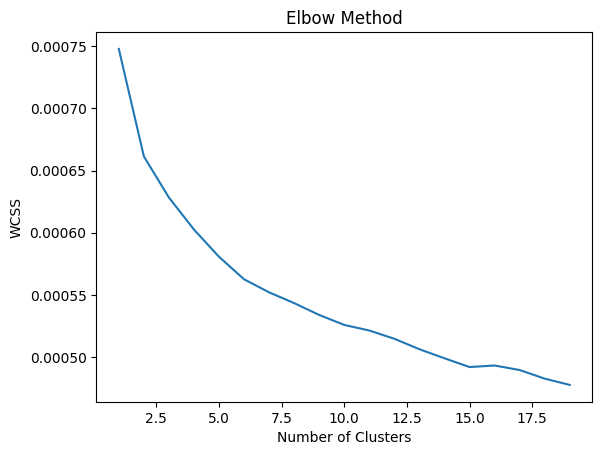

In [12]:
# Initialize list to store WCSS values
wcss = []

# Fit K-Means for a range of cluster numbers
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(result_df.drop('episode_id', axis=1))
    wcss.append(kmeans.inertia_)  # inertia_ contains the WCSS value

# Plot WCSS vs. number of clusters
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

En principio, el codo estaría alrededor de 5.

In [13]:
n = 5
kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(result_df.drop('episode_id', axis=1))

cluster_labels = kmeans.labels_
result_df['Cluster'] = cluster_labels

result_df.reset_index(inplace=True)

### Visualizando Clusters a lo largo de las temporadas y episodios

In [14]:
result_df2 = result_df[['episode_id', 'Cluster']]
result_df2 = pd.merge(result_df2, df_episode[['id', 'season', 'number_in_season', 'season_group']], left_on='episode_id', right_on='id')

In [15]:
#Create a pivot table with episodes and ratigns
ep_piv = result_df2.pivot_table(index='season', columns='number_in_season', values='Cluster')
ep_piv.head()

number_in_season,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
season,,,,,,,,,,,,,,,,,,,,,
1,0.0,2.0,4.0,0.0,2.0,0.0,0.0,2.0,0.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,3.0,0.0,3.0,4.0,0.0,2.0,2.0,4.0,3.0,...,0.0,4.0,3.0,2.0,0.0,2.0,3.0,NaN,NaN,NaN
3,2.0,4.0,4.0,2.0,3.0,1.0,4.0,0.0,0.0,4.0,...,2.0,3.0,2.0,4.0,0.0,1.0,1.0,1.0,4.0,NaN
4,2.0,4.0,0.0,2.0,0.0,0.0,3.0,2.0,0.0,0.0,...,4.0,3.0,0.0,4.0,1.0,1.0,1.0,NaN,NaN,NaN
5,4.0,1.0,4.0,3.0,2.0,4.0,4.0,2.0,4.0,3.0,...,4.0,0.0,3.0,1.0,1.0,3.0,0.0,NaN,NaN,NaN


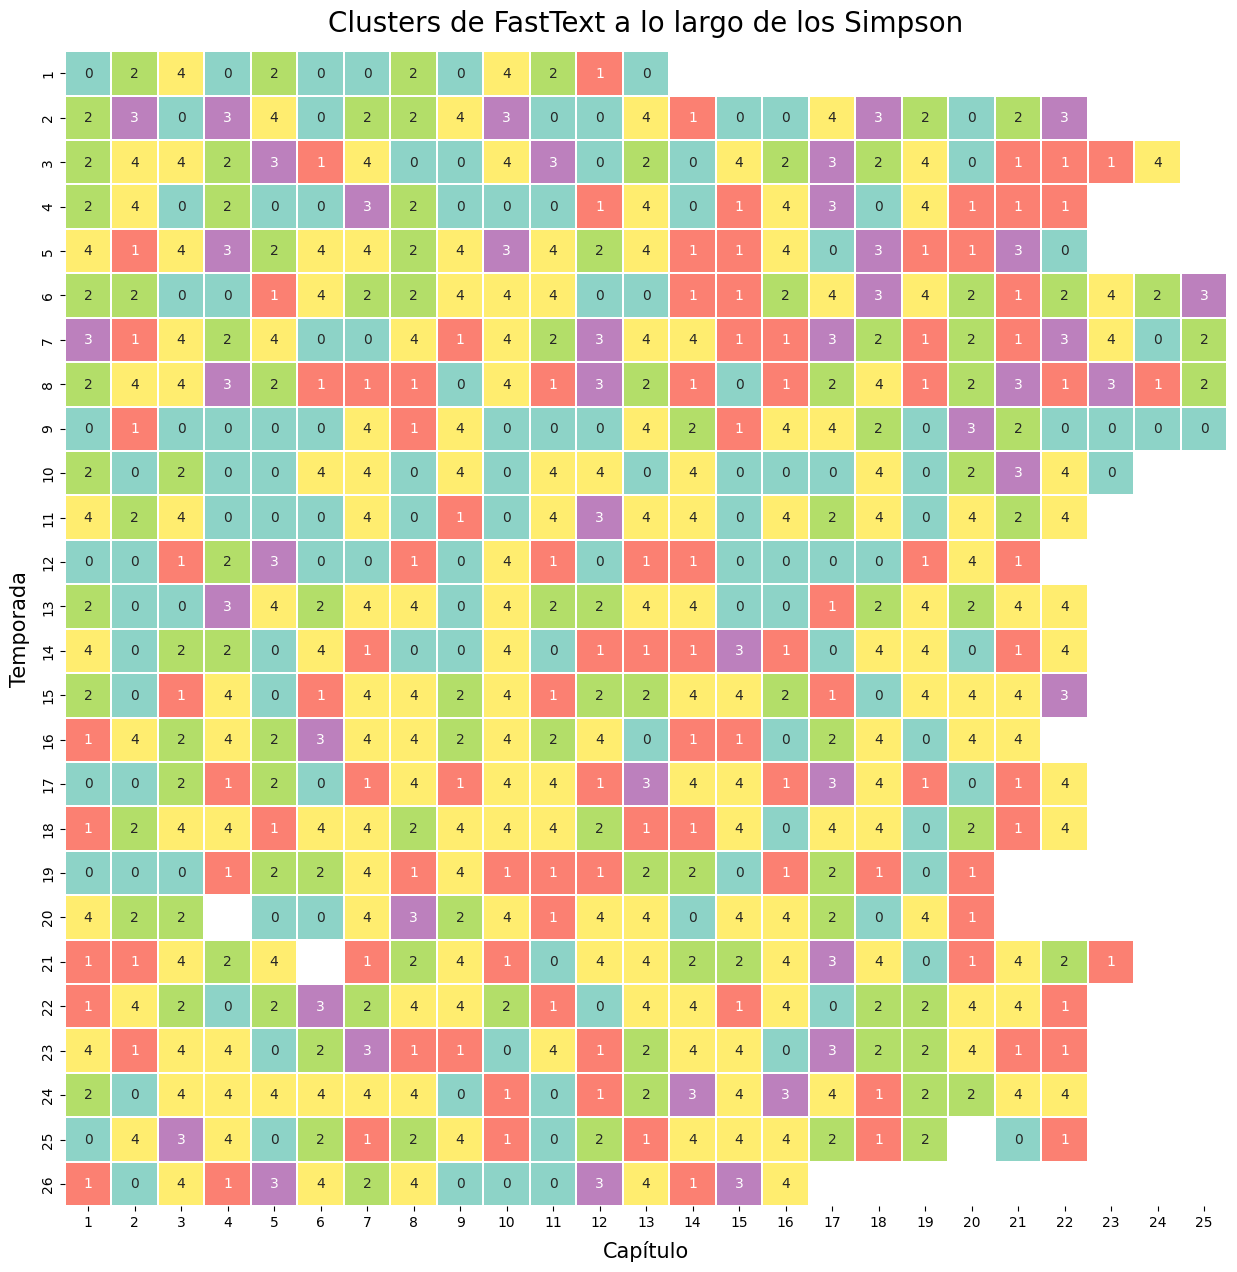

In [16]:
#Heatmap visualization
plt.figure(figsize=(15,15))
sns.heatmap(ep_piv, cmap='Set3', annot=True, linewidths=0.2,cbar_kws={'label': 'Cluster'}, cbar=False)
plt.xlabel('Capítulo', fontsize=15, labelpad=8)
plt.ylabel('Temporada', fontsize=15, labelpad=8)
plt.title('Clusters de FastText a lo largo de los Simpson', fontsize=20, pad=14)
plt.show()

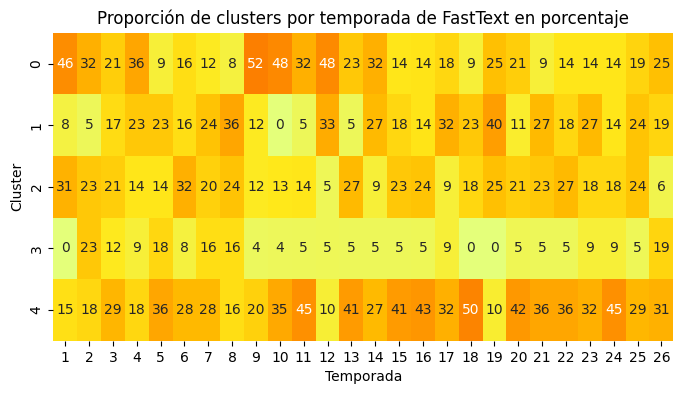

In [17]:
confusion_matrix = pd.crosstab(index=result_df2['Cluster'], columns=result_df2['season'])
row_sums = confusion_matrix.sum(axis=0)
confusion_matrix_relative = confusion_matrix.div(row_sums, axis=1) * 100

plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix_relative, annot=True, cmap='Wistia', fmt='.0f', cbar=False)
plt.xlabel('Temporada')
plt.ylabel('Cluster')
plt.title('Proporción de clusters por temporada de FastText en porcentaje')
plt.show()

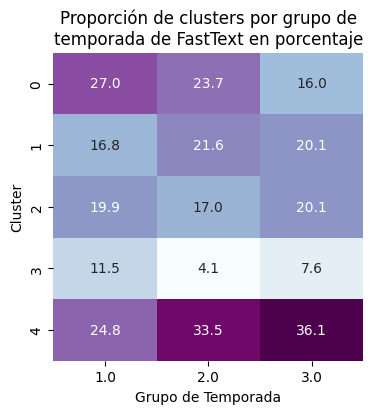

In [18]:
confusion_matrix = pd.crosstab(index=result_df2['Cluster'], columns=result_df2['season_group']) # Confussion matrix with absolute numbers
row_sums = confusion_matrix.sum(axis=0)
confusion_matrix_relative = confusion_matrix.div(row_sums, axis=1) * 100  # Multiply by 100 to get percentages, confussion matrix with relative numbers

plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix_relative, annot=True, cmap='BuPu', fmt='.1f', cbar=False)  # fmt='.1f' for one decimal place
plt.xlabel('Grupo de Temporada')
plt.ylabel('Cluster')
plt.title('Proporción de clusters por grupo de\ntemporada de FastText en porcentaje')

plt.show()


# 3D

In [21]:
result_df.sample()

,index,episode_id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,Cluster
391,391,392,0.000219,0.000147,-0.00003,-0.000139,0.000387,0.000122,-0.000398,-0.000111,...,0.000115,0.00047,-0.00026,-0.00008,-0.000409,-0.000265,-0.00002,-0.000155,-0.000168,1


In [24]:
X_3d = result_df.drop(['index', 'episode_id', 'Cluster'],axis=1)
y_pred = result_df['Cluster']

In [27]:
pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(X_3d)

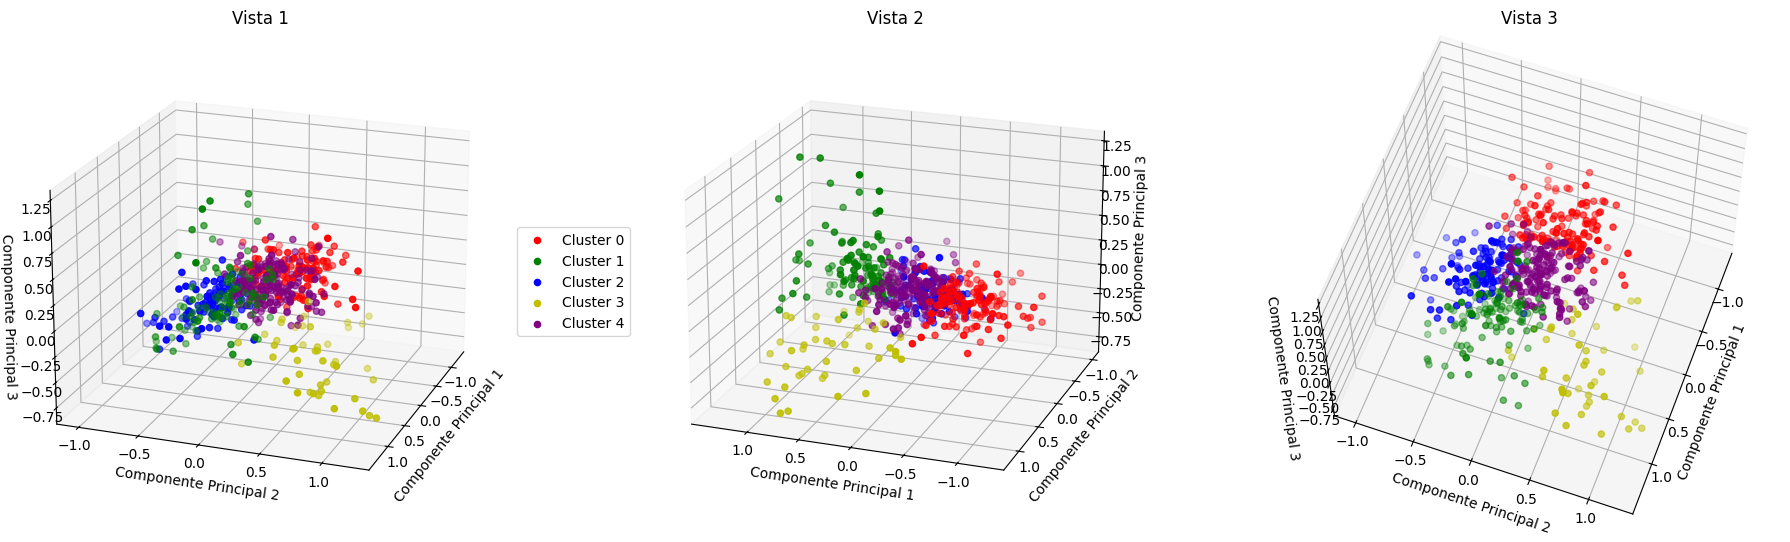

In [35]:
# Crear la figura
fig = plt.figure(figsize=(18, 6))

# Lista de perspectivas (elevación y azimut)
perspectives = [(20, 20), (20, 110), (60, 20)]

# Colores para los clusters
colors = ['r', 'g', 'b', 'y', 'purple']

# Graficar los datos y colorear por cluster desde diferentes perspectivas
for idx, (elev, azim) in enumerate(perspectives):
    ax = fig.add_subplot(1, 3, idx + 1, projection='3d')
    for i in range(5):
        ax.scatter(X_3d[y_pred == i, 0]*1000, X_3d[y_pred == i, 1]*1000, X_3d[y_pred == i, 2]*1000, c=colors[i], label=f'Cluster {i}')
    
    # Añadir título y etiquetas
    ax.set_title(f'Vista {idx + 1}')
    ax.set_xlabel('Componente Principal 1', labelpad=-2)
    ax.tick_params(axis='x', pad=-2)
    ax.set_ylabel('Componente Principal 2', labelpad=-2)
    ax.tick_params(axis='y', pad=-2)
    ax.set_zlabel('Componente Principal 3', labelpad=-2)
    ax.tick_params(axis='z', pad=-2)

    # Cambiar perspectiva
    ax.view_init(elev=elev, azim=azim)

    # Añadir leyenda
    if idx == 0:  # Solo añadir leyenda en el primer subplot para evitar duplicados
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Ajustar el layout
plt.tight_layout()

# Mostrar el gráfico
plt.show()
